In [1]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold

from collections import defaultdict,Counter
# from imblearn.over_sampling import SMOTE
from PIL import Image

# from kerastuner import HyperModel

Using TensorFlow backend.


In [2]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
def generate_actual_predicted(Y_pred, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [3]:
# loading a test image
import os
from PIL import Image

X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))
    

    
X_all = np.array(X_all)
Y_all = np.array(Y_all)



X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


print(X_all.shape)
print(Y_all.shape)

(3018, 112, 170, 3)
(3018, 8)


## K_fold Evaluation

In [4]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix



mode_version='mel_smote_v1_iter_1-10/mel_smote_v1'
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1
n_split=10
n_classes=8


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    
    file_name = mode_version +'_iter_' +str(count)
   
    # Load Model
    model_file = file_name + '.tflite'
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_file)  
    print('File Name Loaded: ',model_file)
   
    interpreter.resize_tensor_input(0, x_test.shape)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    count+=1

    #generate predictions  
    input_data = x_test
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    y_pred = interpreter.get_tensor(output_details[0]['index'])
    actual, predicted = generate_actual_predicted(y_pred, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_1.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_2.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_3.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_4.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_5.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_6.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_7.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_8.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_9.tflite
File Name Loaded:  mel_smote_v1_iter_1-10/mel_smote_v1_iter_10.tflite


In [5]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9997168809792601
Std  0.0005277090025304329
Sp:  M.emarginatus
AUC Mean  0.9981248316797554
Std  0.003243521918043717
Sp:  P.kuhli
AUC Mean  0.9989190218723566
Std  0.001088258163528581
Sp:  R.muscatellum
AUC Mean  0.9988004725253014
Std  0.0005660833331284751
Sp:  R.nasutus
AUC Mean  0.9977028189436948
Std  0.00618798678714313
Sp:  R.aegyptius
AUC Mean  0.9983029073698445
Std  0.00250779382945464
Sp:  T.perforatus
AUC Mean  0.9989634182009102
Std  0.0009740138488832367


In [6]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.95087912 0.93426573 0.98003888 0.98511791 0.98161376
 0.91516484 0.97028656]
precision sdev by class [0.         0.06877409 0.07167065 0.02152739 0.01096595 0.02474959
 0.07455183 0.02447911]
macro precision mean 0.9646708497125891
macro precision sdev 0.00948688088010315
recall mean [0.93333333 0.97628205 0.90984848 0.96655172 0.98499747 0.96666667
 0.95833333 0.97268293]
recall sdev [0.2        0.03626755 0.0909375  0.03944204 0.00720014 0.01994505
 0.08539126 0.03043385]
macro recall mean 0.9585869994200908
macro recall sdev 0.026339636498893596
f1 mean [0.95       0.96114505 0.9171614  0.9727432  0.9850041  0.97393304
 0.93074303 0.97138197]
f1 sdev [0.15       0.03350801 0.05222791 0.02374543 0.00577472 0.01883125
 0.04280382 0.0258254 ]
macro f1 mean 0.9577639760438952
macro f1 sdev 0.02003364570892603
accuracy mean 0.9751468614551936
accuracy sdev 0.009046717746562927


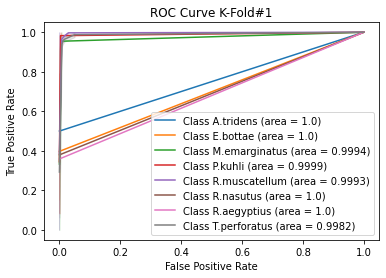

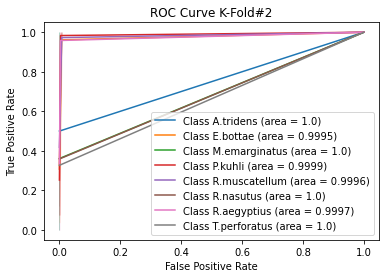

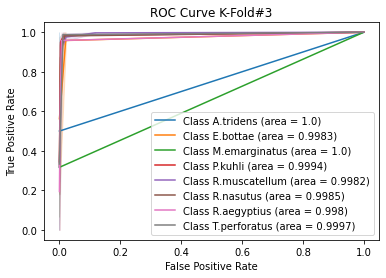

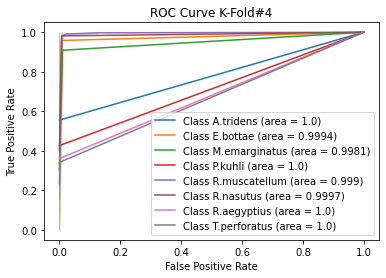

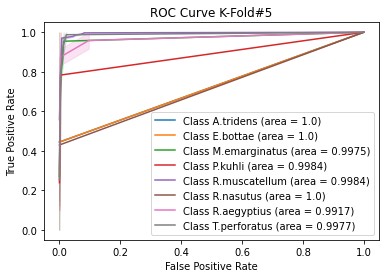

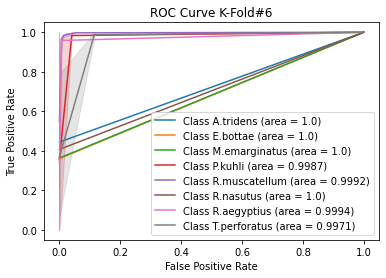

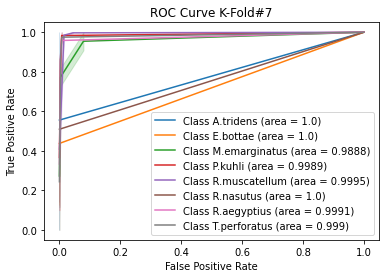

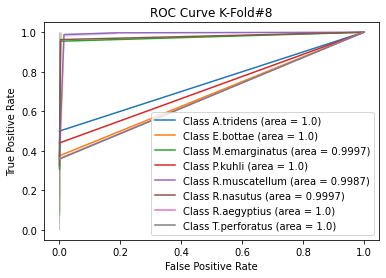

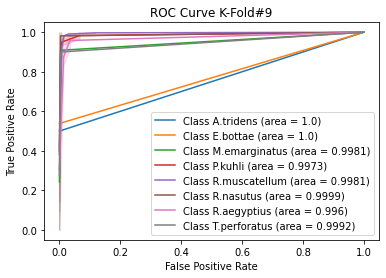

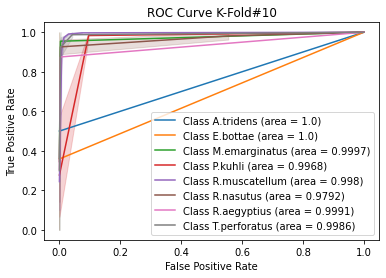

In [9]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

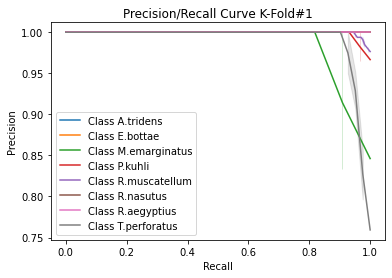

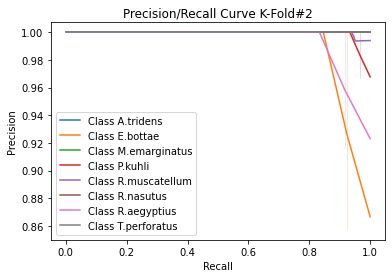

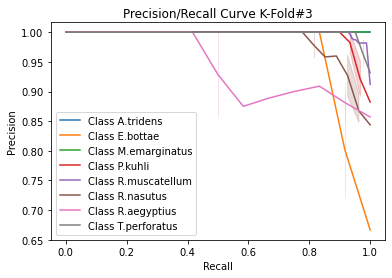

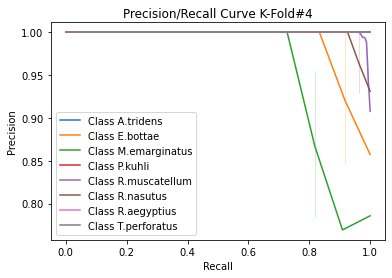

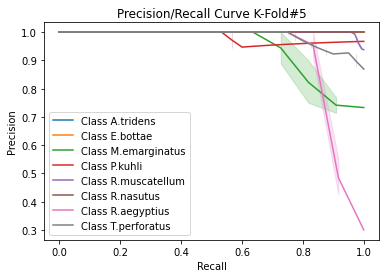

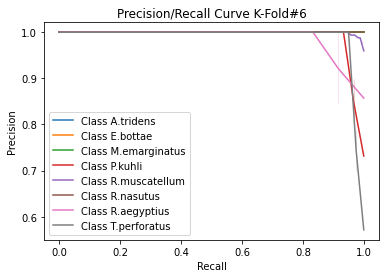

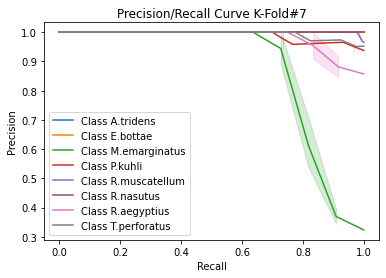

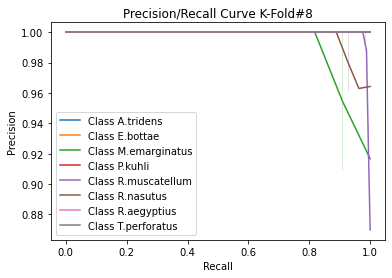

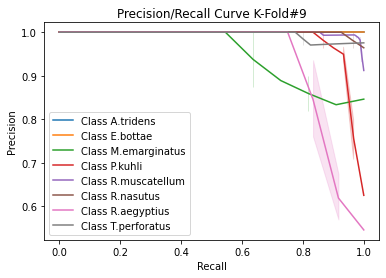

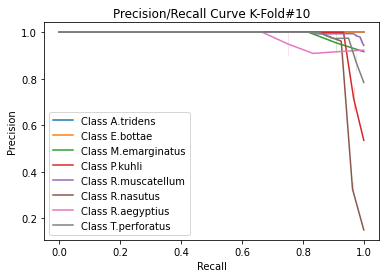

In [10]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   1  10   0   0   0   0   0]
 [  0   0   0  28   1   0   0   0]
 [  0   0   1   0 163   0   0   2]
 [  0   0   0   1   0  26   0   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   0  29   1   0   0   0]
 [  0   0   1   0 164   0   1   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  11   0   0   0   0   1]
 [  0   0   0  28   1   1   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   0   0   0   1  25   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

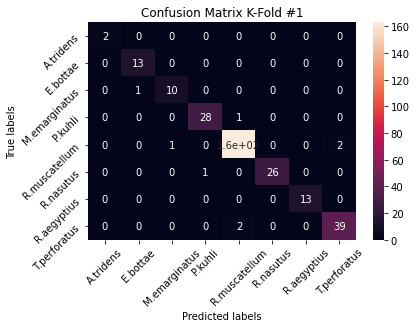

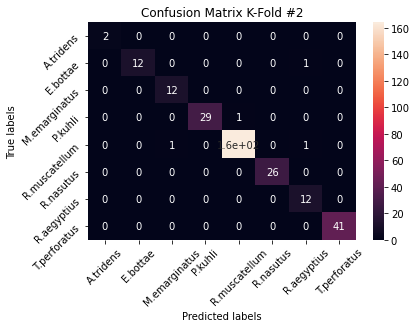

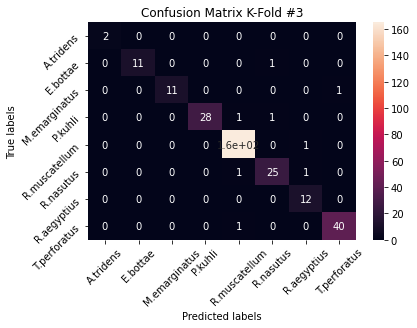

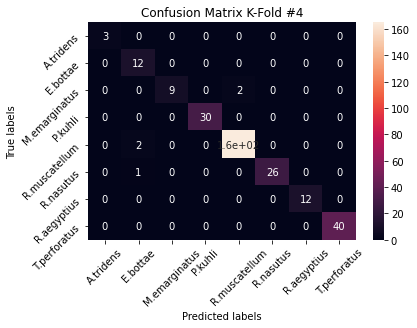

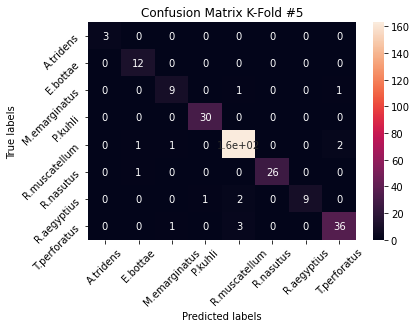

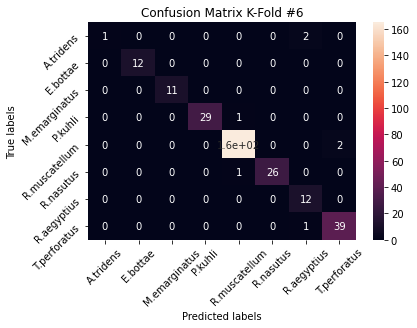

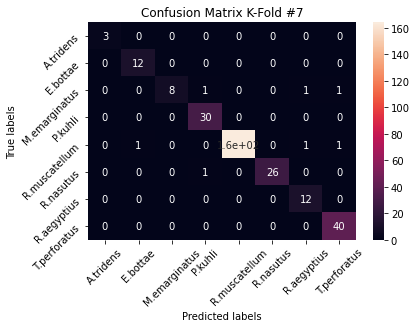

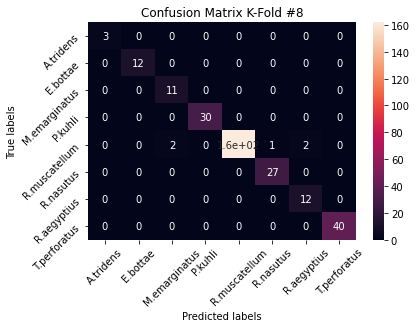

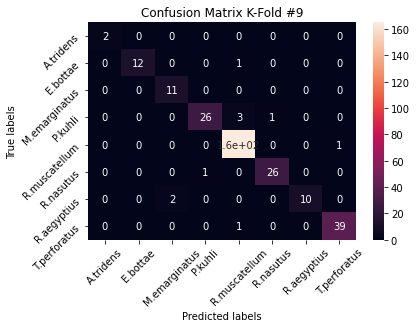

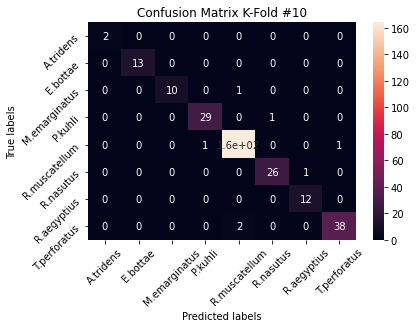

In [11]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  121    0    0    1    1    1    0]
 [   0    1  102    1    4    0    1    3]
 [   0    0    0  289    7    3    0    0]
 [   0    4    5    1 1640    1    5    9]
 [   0    2    0    3    2  260    2    0]
 [   0    0    2    1    2    0  116    0]
 [   0    0    1    0    9    0    1  392]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  39]]


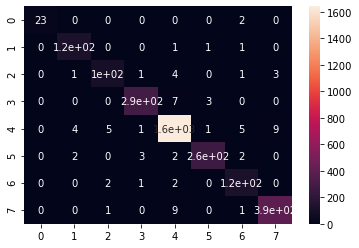

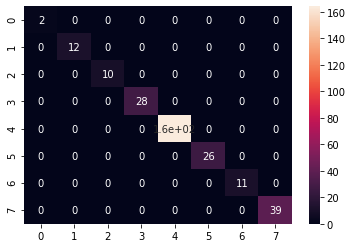

In [12]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.98 0.   0.   0.01 0.01 0.01 0.  ]
 [0.   0.01 0.91 0.01 0.04 0.   0.01 0.03]
 [0.   0.   0.   0.97 0.02 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.   0.01]
 [0.   0.01 0.   0.01 0.01 0.97 0.01 0.  ]
 [0.   0.   0.02 0.01 0.02 0.   0.96 0.  ]
 [0.   0.   0.   0.   0.02 0.   0.   0.97]]


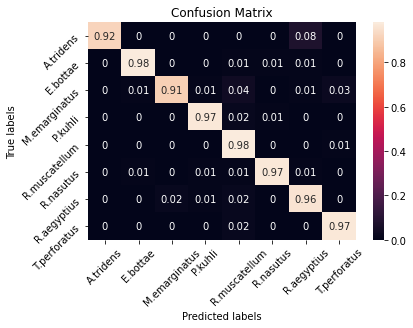

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

## Appendix- what each interpreter function does or looks like

In [19]:
input_details = interpreter.get_input_details()
print (input_details) # stores the details in key value format of the input layer at the top

[{'name': 'input_3', 'index': 0, 'shape': array([  1, 112, 170,   3]), 'shape_signature': array([ -1, 112, 170,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [20]:
output_details = interpreter.get_output_details()
print (output_details) # stores the details in key value format of the output layer at the the end of the model

[{'name': 'Identity', 'index': 25, 'shape': array([1, 8]), 'shape_signature': array([-1,  8]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
output_details[0]['index']

25

In [21]:
print (interpreter.allocate_tensors())

None
